In [3]:
#creating each subject and group level matrices
import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, input_data
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Atlas paths
atlas_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.nii.gz'
labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def read_glasser_labels(labels_path):
    """Read and parse the Glasser atlas labels file"""
    try:
        with open(labels_path, 'r') as f:
            lines = f.readlines()
            # Parse labels file - structure depends on the file format
            # We'll need to adjust this based on the actual content of your .txt file
            labels = [line.strip() for line in lines if line.strip()]
        logging.info(f"Loaded {len(labels)} region labels")
        return labels
    except Exception as e:
        logging.error(f"Error reading labels file: {e}")
        return None

def apply_glasser_atlas(subject_data, atlas_img):
    # Resample atlas to subject space
    resampled_atlas = image.resample_to_img(atlas_img, subject_data, interpolation='nearest')
    
    # Extract time series data
    atlas_masker = NiftiLabelsMasker(labels_img=resampled_atlas, 
                                    standardize=True,
                                    memory='nilearn_cache', 
                                    verbose=0)
    time_series = atlas_masker.fit_transform(subject_data)
    
    return time_series

def create_connectivity_matrix(ss):
    logging.info(f"Processing subject: {ss}")
    
    # Load Glasser atlas
    atlas_img = nib.load(atlas_path)
    logging.info(f"Loaded Glasser atlas with shape: {atlas_img.shape}")
    
    all_runs_data = []
    
    for rn in runs:
        # Load subject data for this run
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/filtered_func_data_reg.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Run data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        logging.info(f"Loaded run {rn} with shape: {subject_img.shape}")
        
        # Apply atlas and extract time series
        run_data = apply_glasser_atlas(subject_img, atlas_img)
        logging.info(f"Extracted time series with shape: {run_data.shape}")
        all_runs_data.append(run_data)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    logging.info(f"Created {connectivity_matrix.shape} connectivity matrix")
    
    return connectivity_matrix

def calculate_group_matrices():
    all_matrices = []
    
    for ss in subs:
        matrix_path = f'{results_dir}/connectivity_matrices/{ss}_glasser_connectivity_matrix.npy'
        if os.path.exists(matrix_path):
            matrix = np.load(matrix_path)
            all_matrices.append(matrix)
    
    if all_matrices:
        # Calculate mean and std matrices
        all_matrices = np.array(all_matrices)
        mean_matrix = np.mean(all_matrices, axis=0)
        std_matrix = np.std(all_matrices, axis=0)
        
        # Save group-level matrices
        output_dir = f'{results_dir}/connectivity_data'
        os.makedirs(output_dir, exist_ok=True)
        np.save(f'{output_dir}/glasser_group_mean_matrix.npy', mean_matrix)
        np.save(f'{output_dir}/glasser_group_std_matrix.npy', std_matrix)
        logging.info('Saved group-level matrices')

def main():
    # Load atlas labels
    labels = read_glasser_labels(labels_path)
    if labels is None:
        logging.warning("Proceeding without labels")
    
    # Create individual connectivity matrices
    for ss in subs:
        connectivity_matrix = create_connectivity_matrix(ss)
        if connectivity_matrix is not None:
            # Save the connectivity matrix
            output_dir = f'{results_dir}/connectivity_matrices'
            os.makedirs(output_dir, exist_ok=True)
            np.save(f'{output_dir}/{ss}_glasser_connectivity_matrix.npy', connectivity_matrix)
            logging.info(f'Saved connectivity matrix for {ss}')
    
    # Calculate and save group-level matrices
    calculate_group_matrices()

if __name__ == "__main__":
    main()

2024-10-25 17:54:15,739 - INFO - Loaded 180 region labels
2024-10-25 17:54:15,741 - INFO - Processing subject: sub-025
2024-10-25 17:54:15,744 - INFO - Loaded Glasser atlas with shape: (197, 233, 189)
2024-10-25 17:54:15,966 - INFO - Loaded run 1 with shape: (176, 256, 256, 184)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/maskers/nifti_labels_masker.py:614: UserWarning: Persisting input arguments took 12.03s to run.
If this happens often in your code, it can

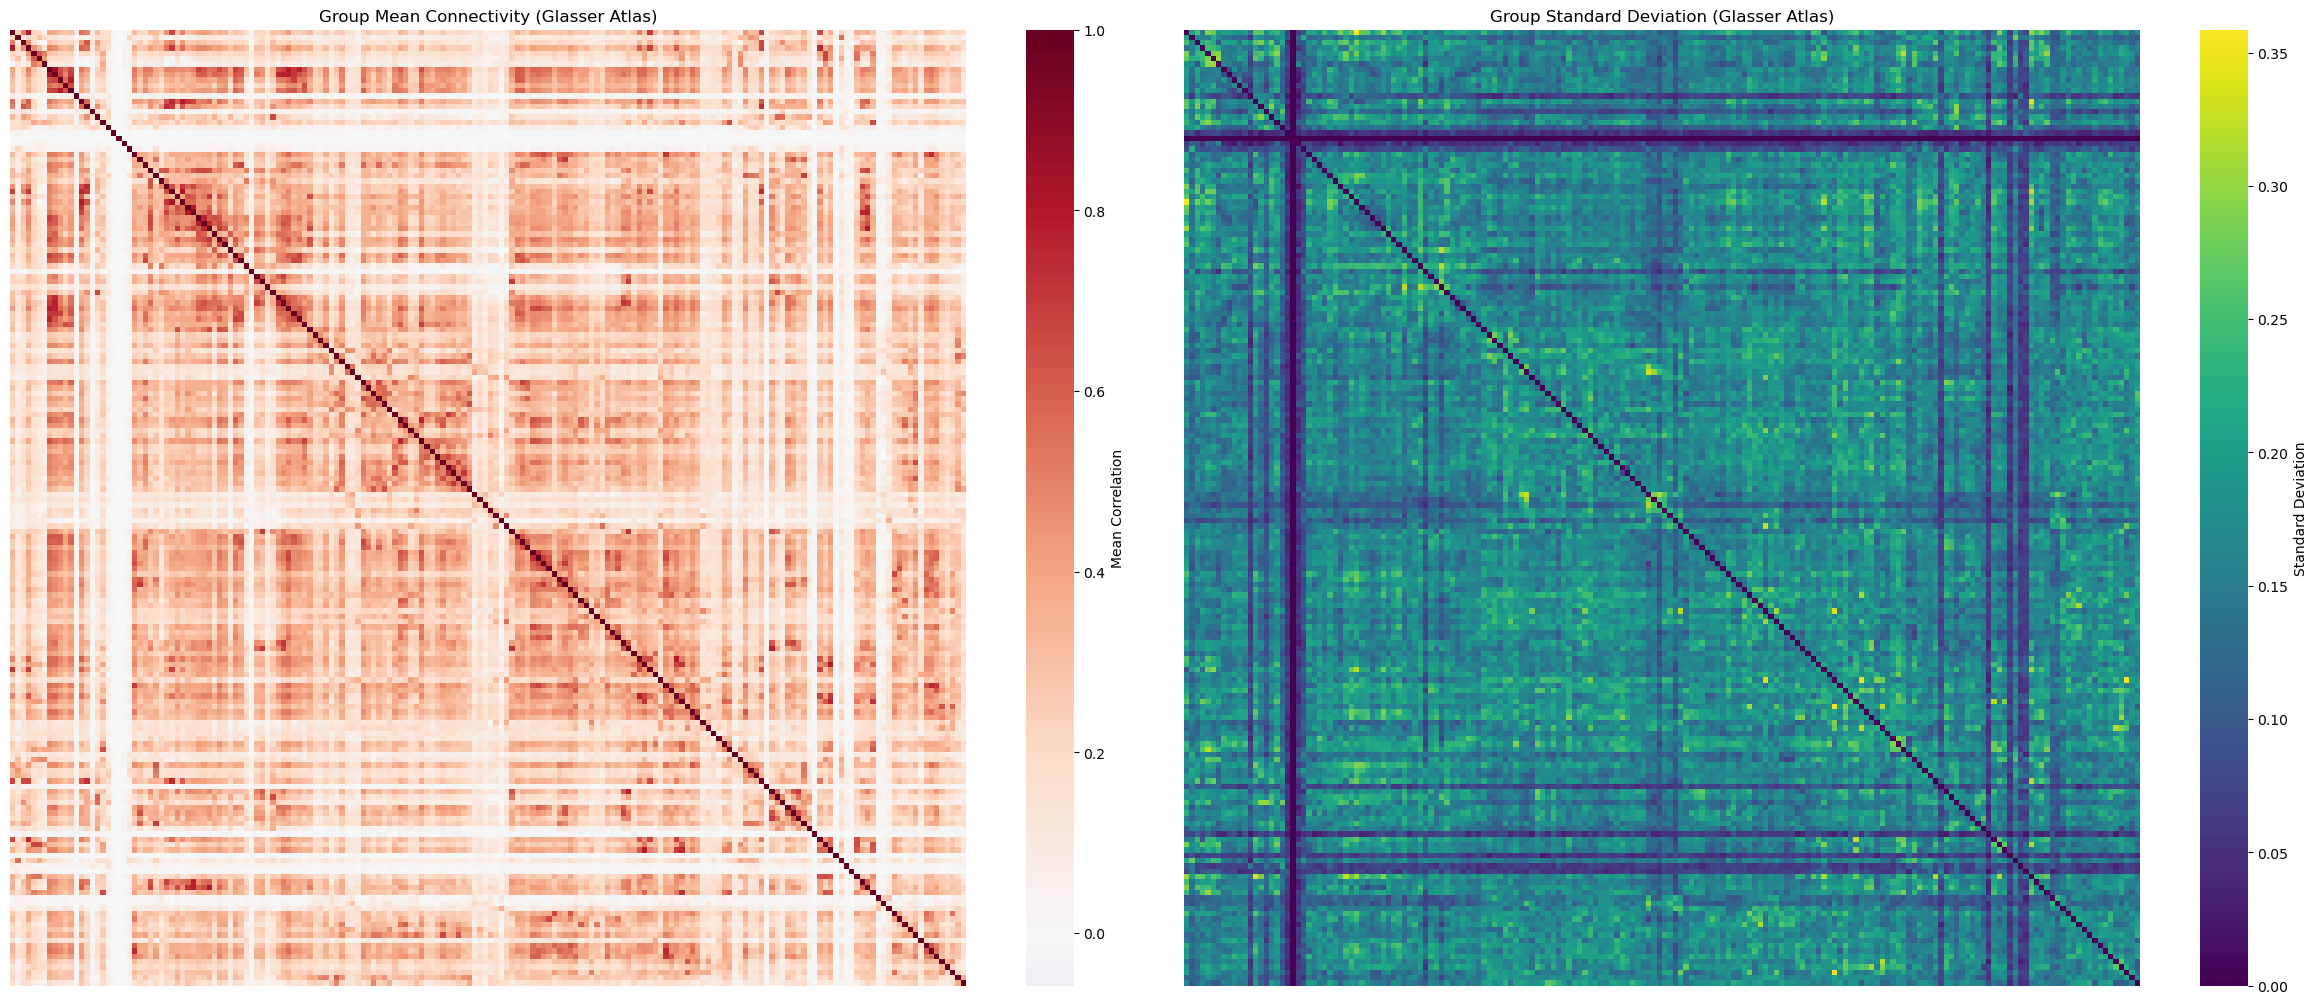


Connectivity Statistics:
Mean correlation range: -0.058 to 1.000
Average correlation: 0.230
Standard deviation range: 0.000 to 0.359


In [1]:
# plotting the group level matrices
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def read_glasser_labels(labels_path):
    """Read Glasser atlas labels"""
    with open(labels_path, 'r') as f:
        # Read lines and extract ROI names, skip the number at start of each line
        labels = [line.split('_ROI')[0].split(' ', 1)[1] for line in f.readlines()]
    return labels

def visualize_connectivity():
    # Paths
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results'
    labels_path = f'{curr_dir}/glasser/HCP-MMP1_on_MNI152_ICBM2009a_nlin.txt'
    
    # Load matrices
    mean_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy')
    std_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_std_matrix.npy')
    
    # Load and process labels
    labels = read_glasser_labels(labels_path)
    
    # Create figure with subplots for mean and std matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot mean matrix
    sns.heatmap(mean_matrix, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Group Mean Connectivity (Glasser Atlas)')
    
    # Plot std matrix
    sns.heatmap(std_matrix, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Group Standard Deviation (Glasser Atlas)')
    
    plt.tight_layout()
    plt.show()
    
    # Print some basic statistics
    print("\nConnectivity Statistics:")
    print(f"Mean correlation range: {mean_matrix.min():.3f} to {mean_matrix.max():.3f}")
    print(f"Average correlation: {mean_matrix.mean():.3f}")
    print(f"Standard deviation range: {std_matrix.min():.3f} to {std_matrix.max():.3f}")
    
    # Create network-level summary if needed
    # We can add this based on your needs

if __name__ == "__main__":
    visualize_connectivity()

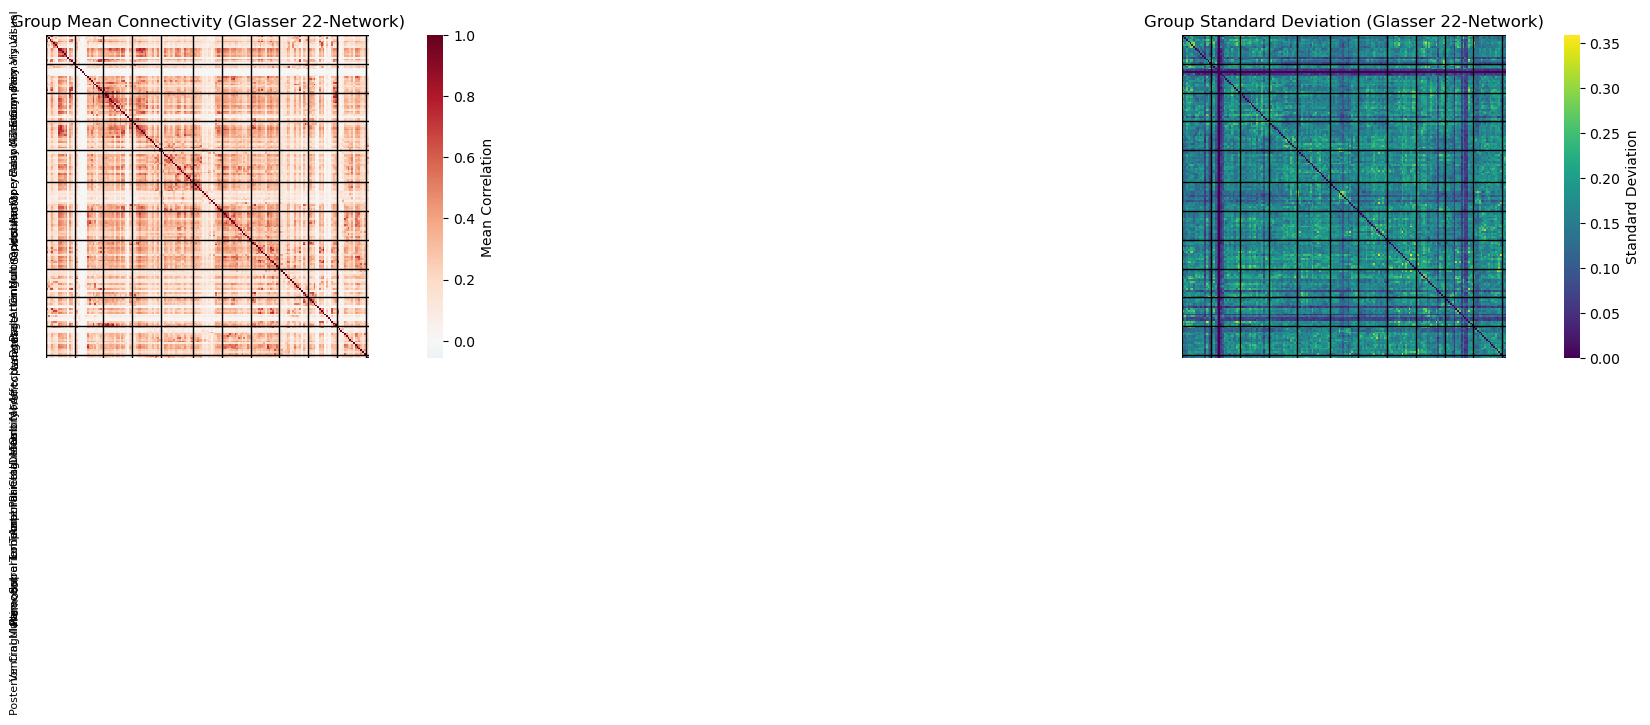

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice.
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice.


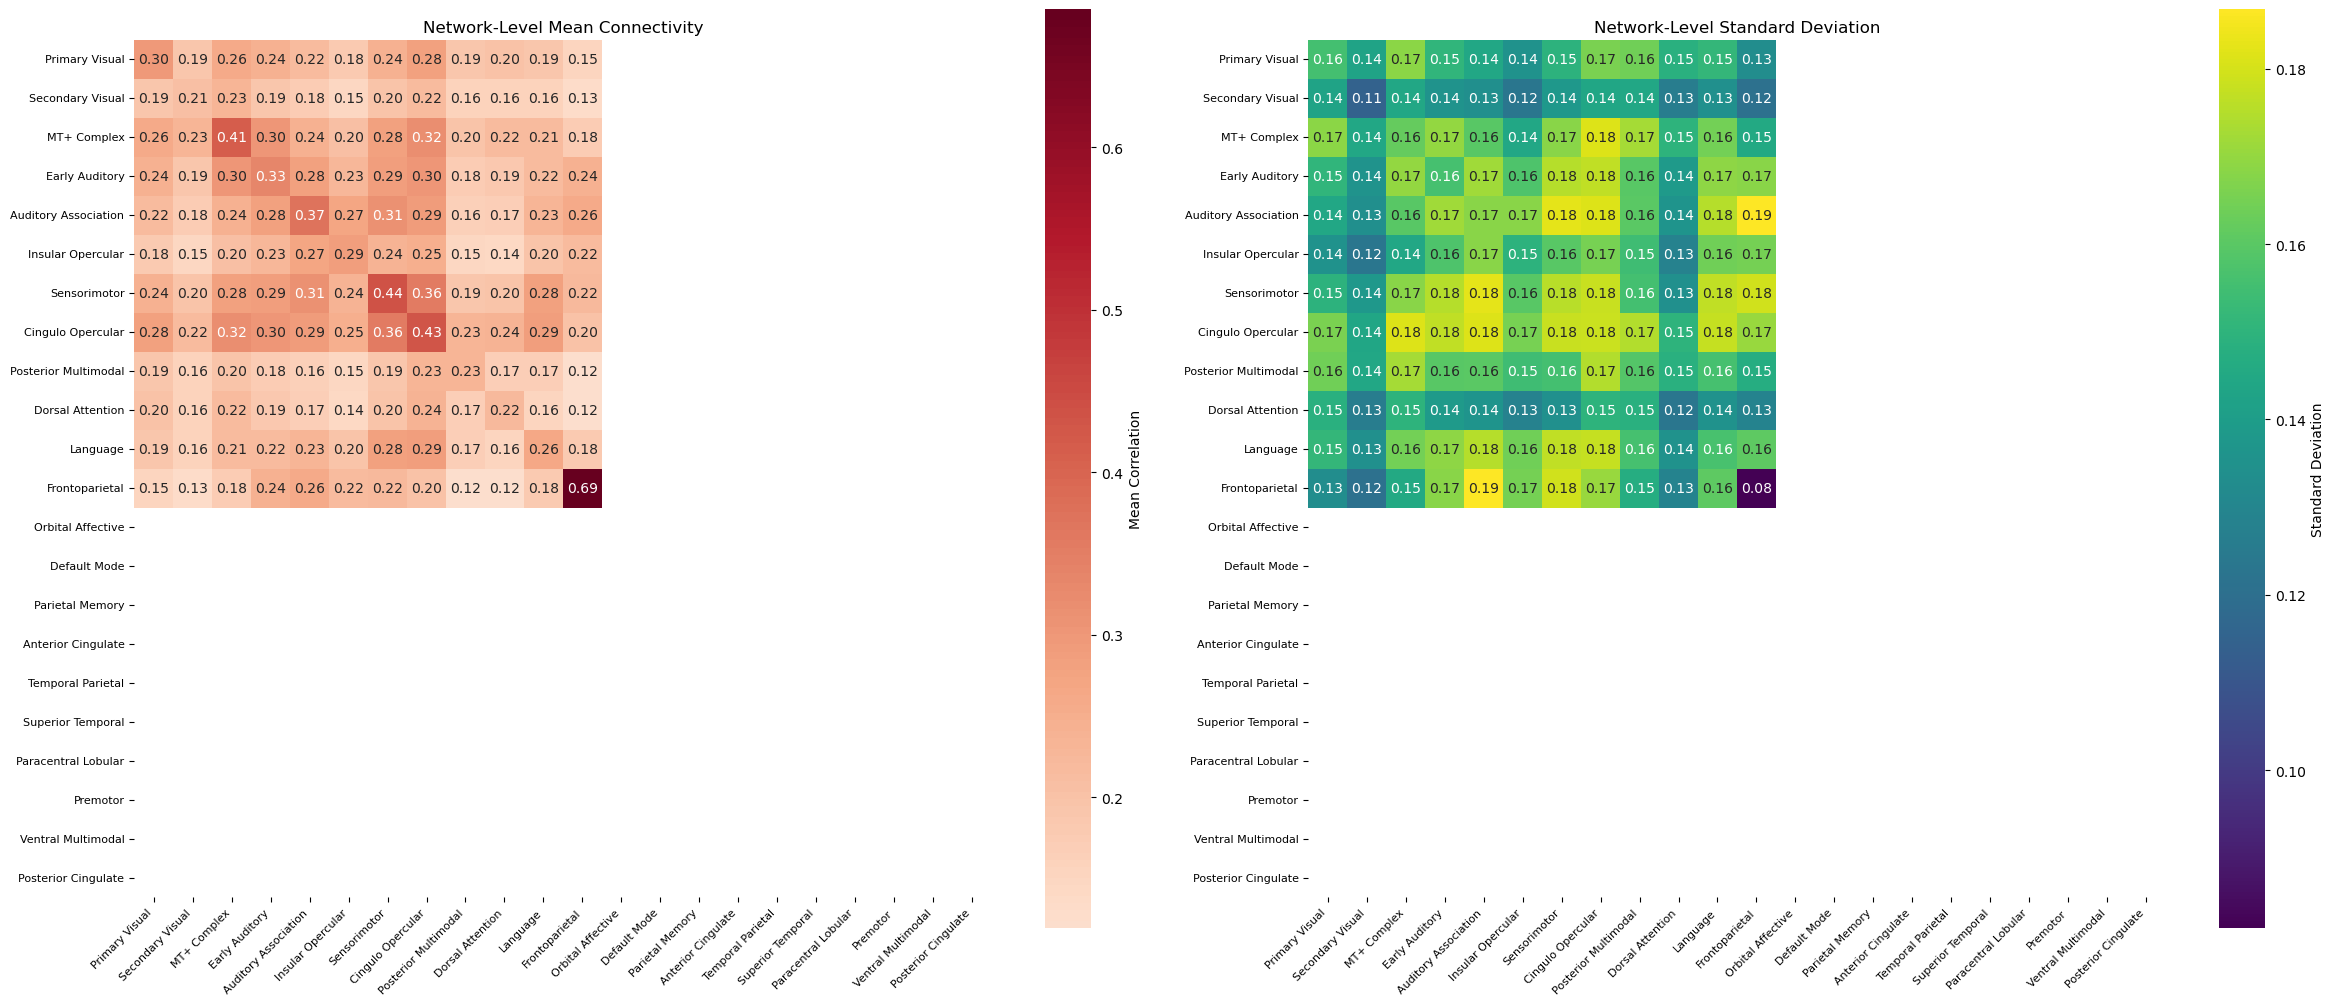

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_22_networks():
    # Paths
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results'
    
    # Load matrices
    mean_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_mean_matrix.npy')
    std_matrix = np.load(f'{results_dir}/connectivity_data/glasser_group_std_matrix.npy')
    
    # Define the 22 networks and their boundaries
    networks = [0, 16, 32, 48, 64, 82, 98, 114, 130, 146, 162, 178, 194, 210, 226, 242, 258, 274, 290, 306, 322, 338, 360]
    network_labels = [
        'Primary Visual',
        'Secondary Visual',
        'MT+ Complex',
        'Early Auditory',
        'Auditory Association',
        'Insular Opercular',
        'Sensorimotor',
        'Cingulo Opercular',
        'Posterior Multimodal',
        'Dorsal Attention',
        'Language',
        'Frontoparietal',
        'Orbital Affective',
        'Default Mode',
        'Parietal Memory',
        'Anterior Cingulate',
        'Temporal Parietal',
        'Superior Temporal',
        'Paracentral Lobular',
        'Premotor',
        'Ventral Multimodal',
        'Posterior Cingulate'
    ]
    
    # Create figure with subplots for mean and std matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Plot mean matrix
    sns.heatmap(mean_matrix, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Group Mean Connectivity (Glasser 22-Network)')
    
    # Add network boundaries and labels to mean matrix
    for idx in networks:
        ax1.axhline(y=idx, color='black', linewidth=1)
        ax1.axvline(x=idx, color='black', linewidth=1)
    
    # Add network labels
    for i in range(len(networks)-1):
        mid_point = (networks[i] + networks[i+1]) // 2
        ax1.text(-20, mid_point, network_labels[i],
                rotation=90, verticalalignment='center', fontsize=8)
    
    # Plot std matrix
    sns.heatmap(std_matrix, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Group Standard Deviation (Glasser 22-Network)')
    
    # Add network boundaries to std matrix
    for idx in networks:
        ax2.axhline(y=idx, color='black', linewidth=1)
        ax2.axvline(x=idx, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Create network-level summary matrices
    network_means = np.zeros((len(network_labels), len(network_labels)))
    network_stds = np.zeros((len(network_labels), len(network_labels)))

    for i in range(len(networks)-1):
        for j in range(len(networks)-1):
            block_mean = mean_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            block_std = std_matrix[networks[i]:networks[i+1], networks[j]:networks[j+1]].mean()
            network_means[i,j] = block_mean
            network_stds[i,j] = block_std

    # Plot network-level summaries
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Network-level mean connectivity
    sns.heatmap(network_means, 
                cmap='RdBu_r',
                center=0,
                square=True,
                ax=ax1,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Mean Correlation'})
    ax1.set_title('Network-Level Mean Connectivity')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax1.get_yticklabels(), fontsize=8)

    # Network-level standard deviation
    sns.heatmap(network_stds, 
                cmap='viridis',
                square=True,
                ax=ax2,
                xticklabels=network_labels,
                yticklabels=network_labels,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Standard Deviation'})
    ax2.set_title('Network-Level Standard Deviation')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax2.get_yticklabels(), fontsize=8)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_22_networks()